In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [36]:
# Load the dataset
file_path = "C:\\Users\\TRINAVA\\Documents\\DailyDelhiClimateTrain.csv"
df = pd.read_csv(file_path)

In [37]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [38]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.dayofyear

In [39]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure,year,month,day
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1,1
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1,2
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1,3
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1,4
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1,5


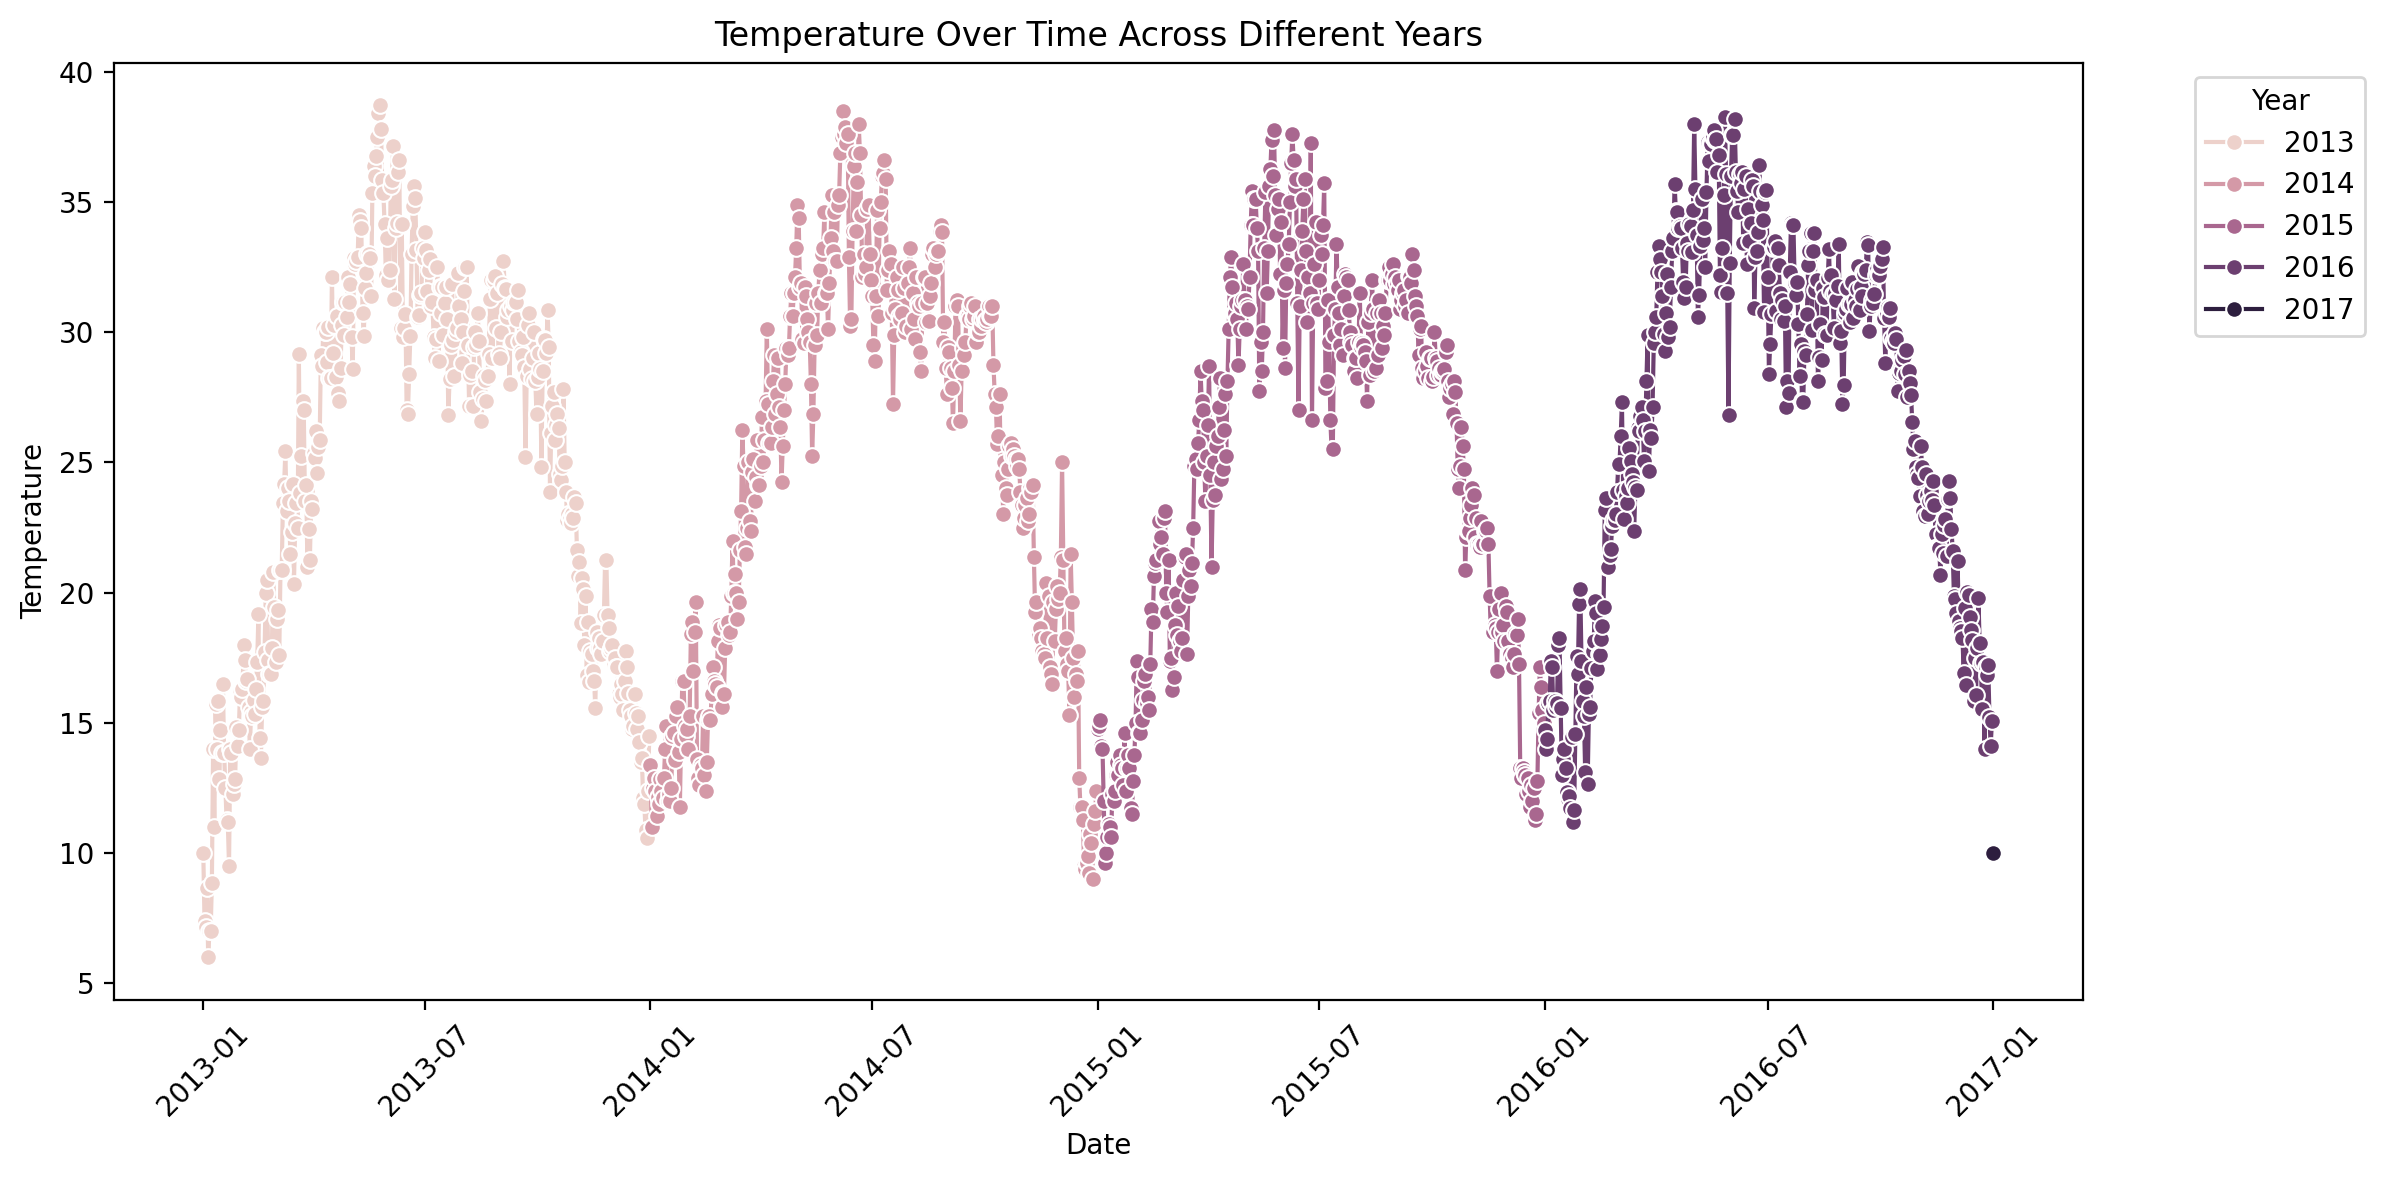

In [40]:
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(data=df, x='date', y='meantemp', hue='year', marker='o')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Over Time Across Different Years')
plt.xticks(rotation=45)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

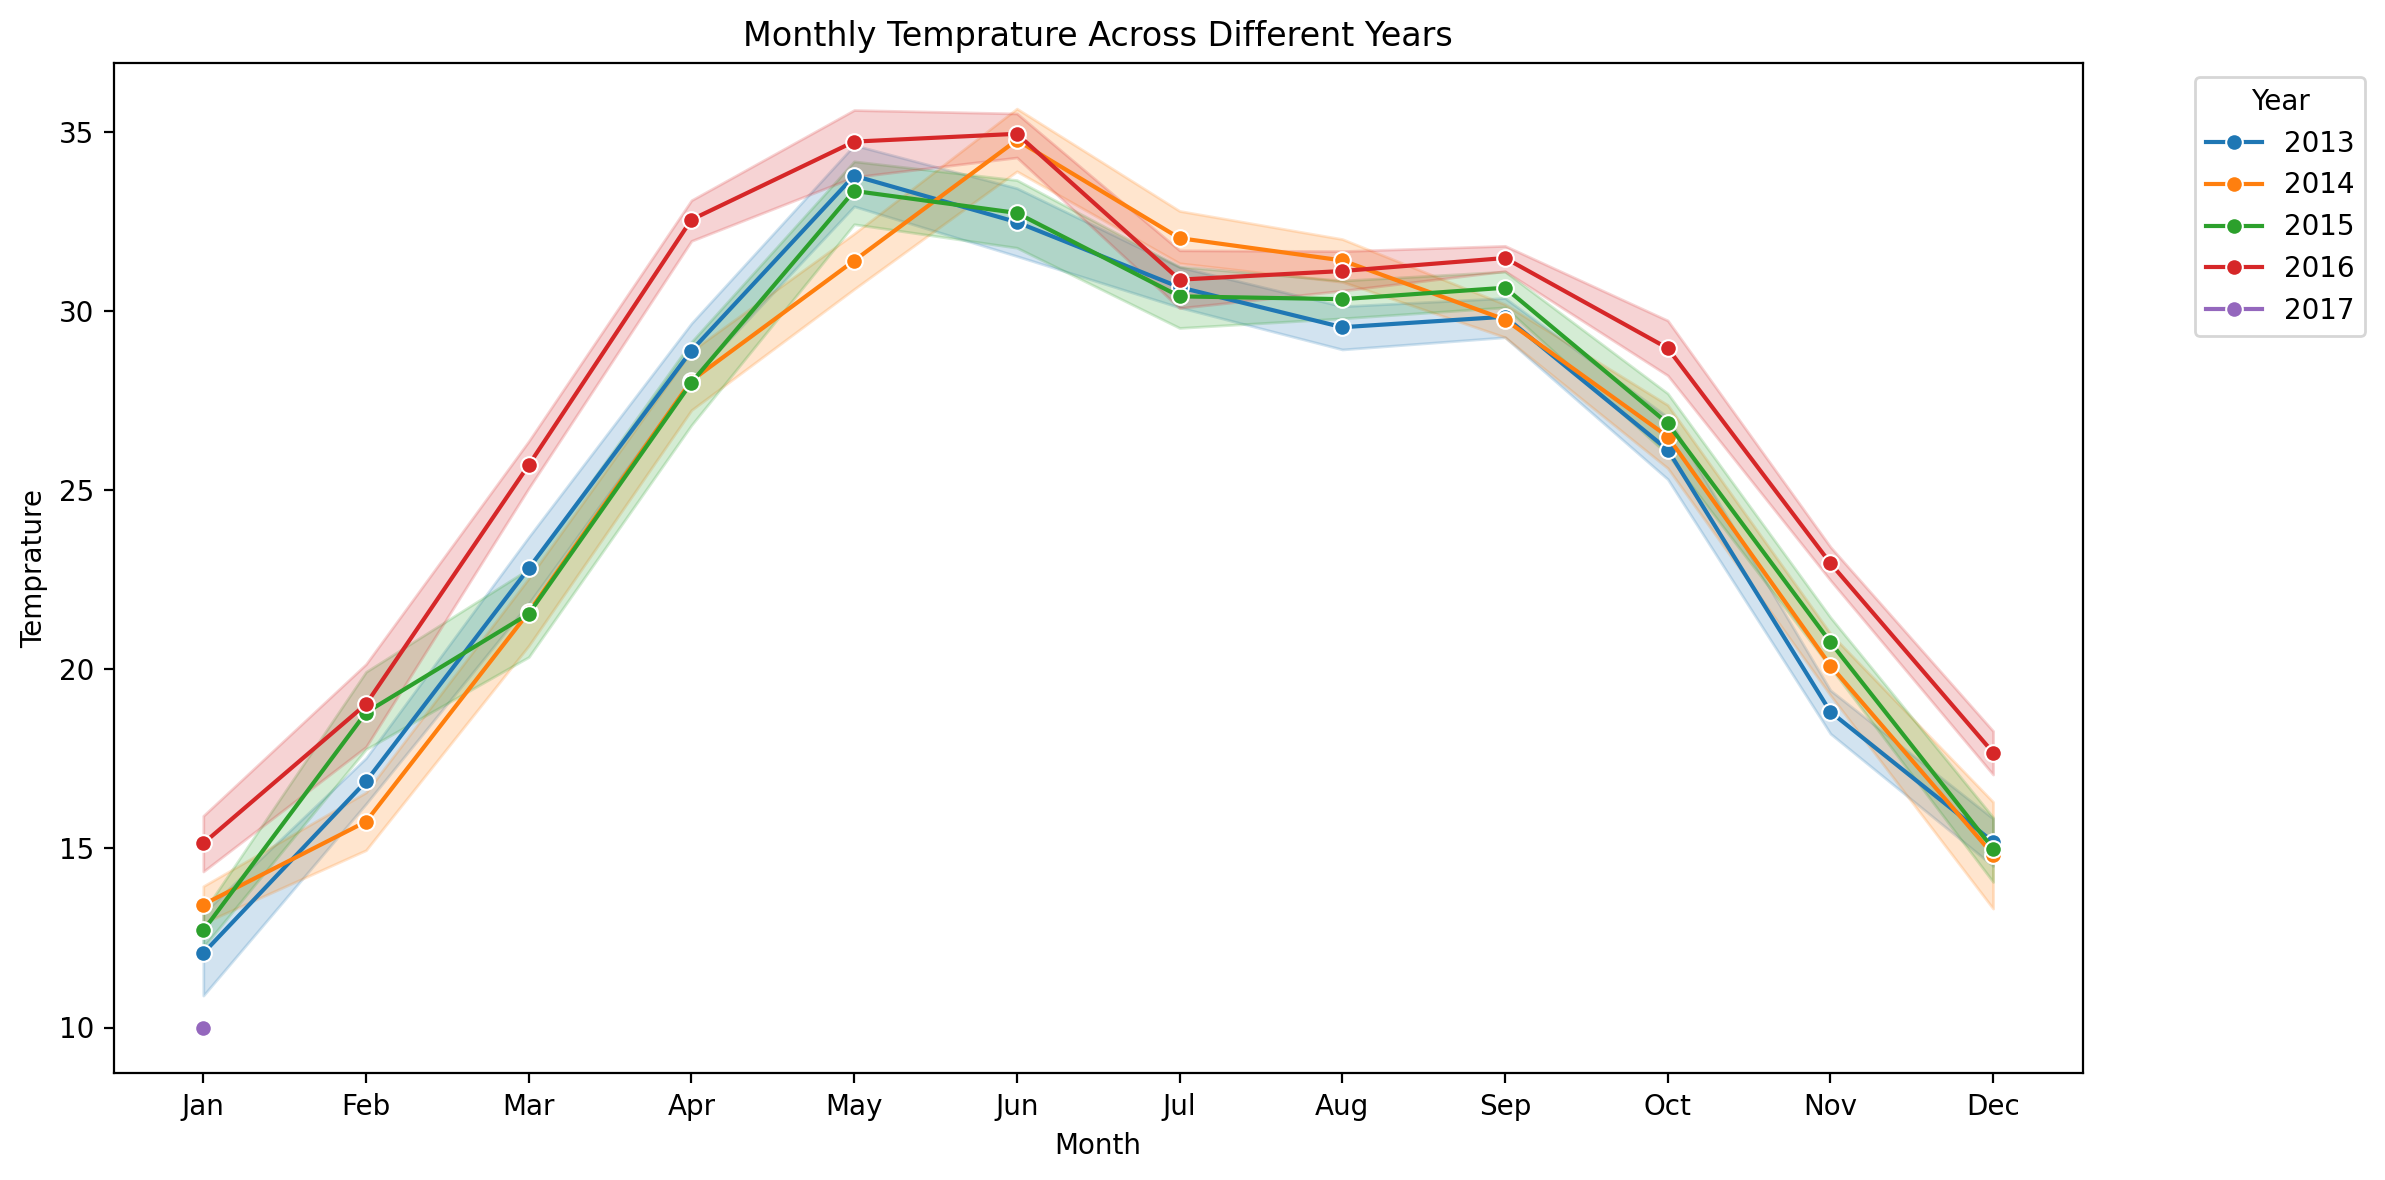

In [41]:
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(data=df, x='month', y='meantemp', hue='year', marker='o', palette='tab10')
plt.xlabel('Month')
plt.ylabel('Temprature')
plt.title('Monthly Temprature Across Different Years')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [42]:
df1 = df.copy()
df1

,date,meantemp,humidity,wind_speed,meanpressure,year,month,day
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1,1
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1,2
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1,3
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1,4
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1,5
...,...,...,...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217,2016,12,363
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762,2016,12,364
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762,2016,12,365
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000,2016,12,366


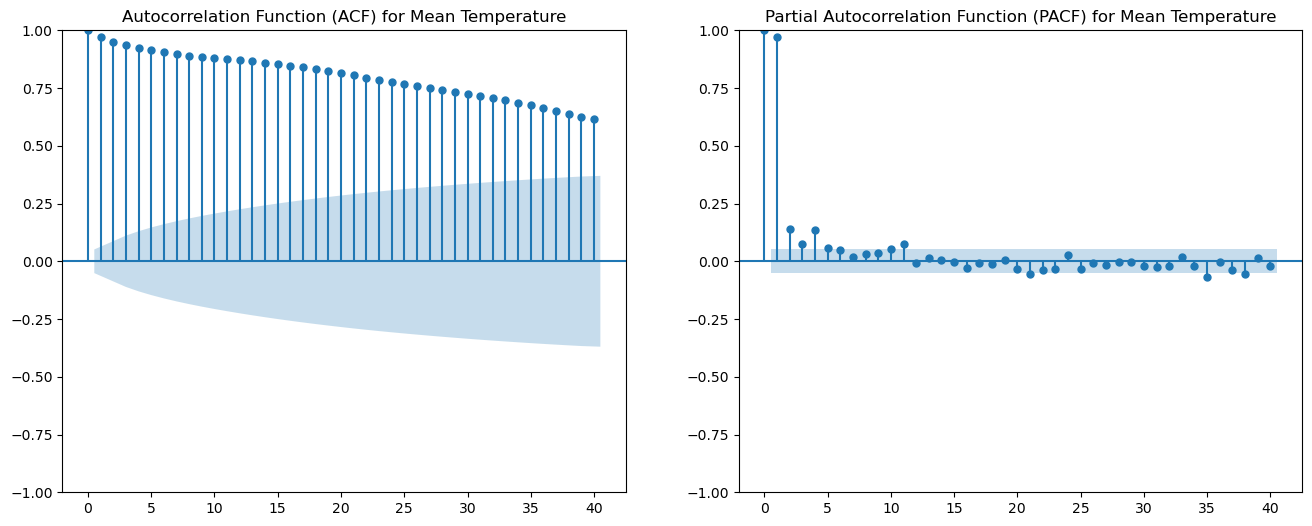

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot ACF
plot_acf(df1['meantemp'], ax=axes[0], lags=40, title='Autocorrelation Function (ACF) for Mean Temperature')

# Plot PACF
plot_pacf(df1['meantemp'], ax=axes[1], lags=40, title='Partial Autocorrelation Function (PACF) for Mean Temperature')

plt.show()

In [45]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

def check_stationarity(series):
    print(f'\n___________________Checking Stationarity for: {series.name}___________________\n')
    
    # ADF Test
    adf_test = adfuller(series.values)
    print('ADF Test:\n')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    if (adf_test[1] <= 0.05) & (adf_test[4]['5%'] > adf_test[0]):
        print("\u001b[32mSeries is Stationary (ADF Test)\u001b[0m")
    else:
        print("\x1b[31mSeries is Non-stationary (ADF Test)\x1b[0m")
    
    print('\n' + '-'*50 + '\n')
    
    # KPSS Test
    kpss_test = kpss(series.values, regression='c', nlags='auto')
    print('KPSS Test:\n')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))

    if kpss_test[1] > 0.05:
        print("\u001b[32mSeries is Stationary (KPSS Test)\u001b[0m")
    else:
        print("\x1b[31mSeries is Non-stationary (KPSS Test)\x1b[0m")

In [46]:
# Check initial stationarity for each feature

check_stationarity(df1['meantemp'])


___________________Checking Stationarity for: meantemp___________________

ADF Test:

ADF Statistic: -2.021069
p-value: 0.277412
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Series is Non-stationary (ADF Test)

--------------------------------------------------

KPSS Test:

KPSS Statistic: 0.187864
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Series is Stationary (KPSS Test)


In [47]:
df1['meantemp_diff'] = df1['meantemp'].diff().fillna(0)  # diff() default is 1st degree differencing 


check_stationarity(df1['meantemp_diff']);


___________________Checking Stationarity for: meantemp_diff___________________

ADF Test:

ADF Statistic: -16.294070
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Series is Stationary (ADF Test)

--------------------------------------------------

KPSS Test:

KPSS Statistic: 0.189493
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Series is Stationary (KPSS Test)


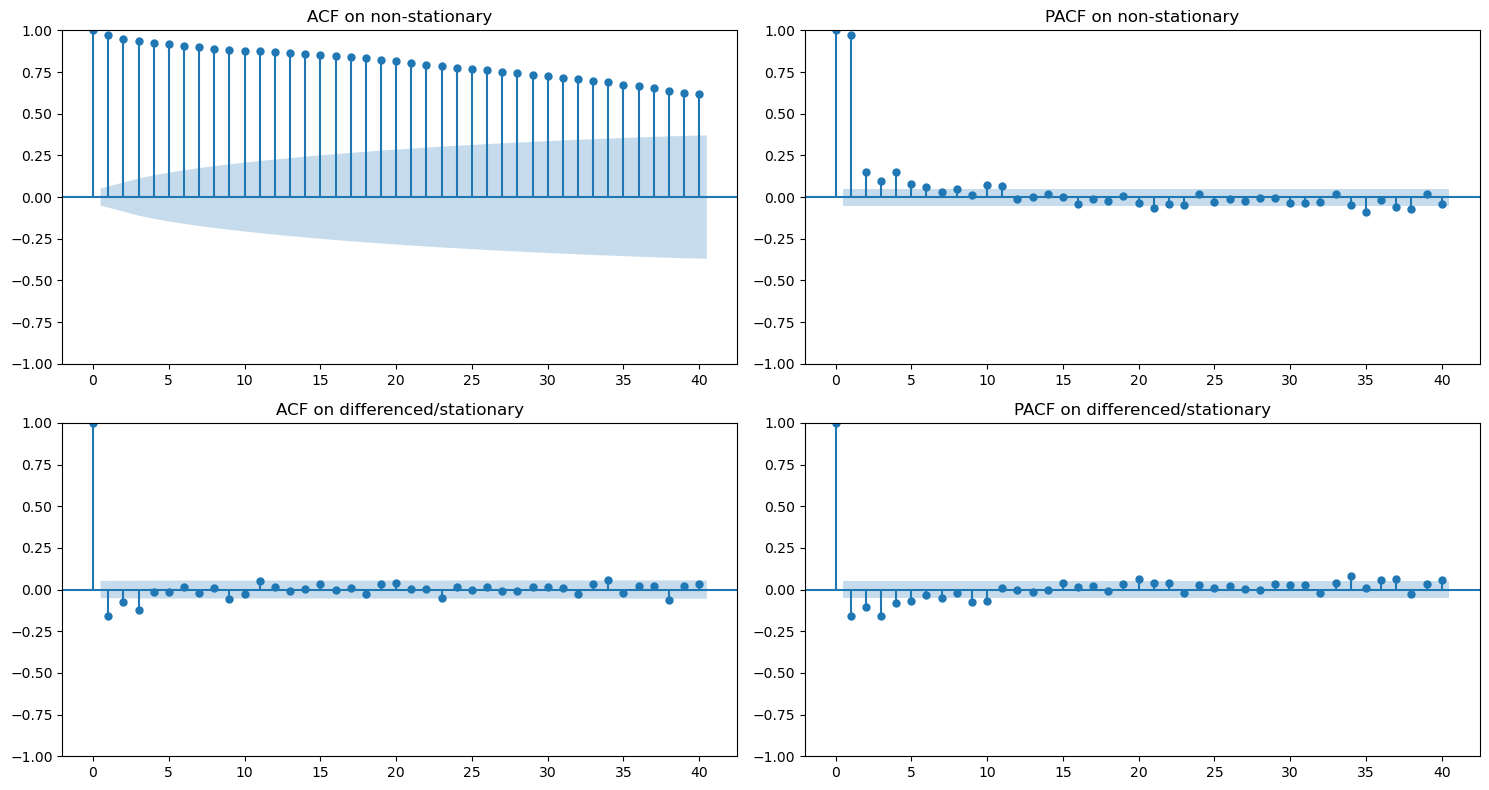

In [48]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

plot_acf(df1['meantemp'], lags=40, ax=ax[0, 0], title='ACF on non-stationary')
plot_pacf(df1['meantemp'], lags=40, ax=ax[0, 1], method='ols', title='PACF on non-stationary')

plot_acf(df1['meantemp_diff'], lags=40, ax=ax[1, 0], title='ACF on differenced/stationary')
plot_pacf(df1['meantemp_diff'], lags=40, ax=ax[1, 1], method='ols', title='PACF on differenced/stationary')

plt.tight_layout()
plt.show()

In [49]:
# Split the data into training and testing sets
train_size = int(len(df1) * 0.8)
train, test = df1.iloc[:train_size], df1.iloc[train_size:]

In [50]:
display(f'Train shape: {train.shape}')
display(train.head())

display(f'Test shape: {test.shape}')
test.head()

'Train shape: (1169, 9)'

,date,meantemp,humidity,wind_speed,meanpressure,year,month,day,meantemp_diff
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1,1,0.000000
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1,2,-2.600000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1,3,-0.233333
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1,4,1.500000
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1,5,-2.666667


'Test shape: (293, 9)'

,date,meantemp,humidity,wind_speed,meanpressure,year,month,day,meantemp_diff
1169,2016-03-15,24.066667,58.933333,8.646667,1014.866667,2016,3,75,1.691667
1170,2016-03-16,23.937500,53.750000,10.881250,1012.812500,2016,3,76,-0.129167
1171,2016-03-17,26.312500,50.312500,6.843750,1010.437500,2016,3,77,2.375000
1172,2016-03-18,26.187500,61.250000,6.712500,1009.812500,2016,3,78,-0.125000
1173,2016-03-19,26.785714,61.857143,3.578571,1009.214286,2016,3,79,0.598214


In [67]:
# ARIMA

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Fit the ARIMA model
arima_model = ARIMA(train['meantemp'], order=(1,1,1))  # ARIMA(p,d,q)
arima_model_fit = arima_model.fit()

# Make predictions
arima_pred = arima_model_fit.forecast(steps=len(test))

# Calculate error
error = mean_squared_error(test['meantemp'], arima_pred)
print('Test MSE: %.3f' % error)

Test MSE: 65.649


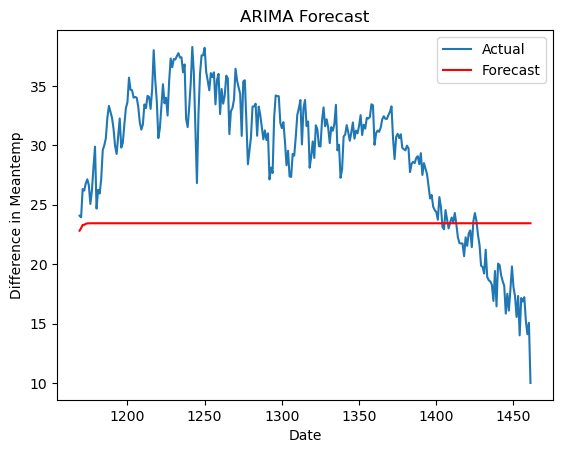

In [59]:
# Plot the results
plt.plot(test.index, test['meantemp'], label='Actual')
plt.plot(test.index, arima_pred, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Difference in Meantemp')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

Best ARIMA Order: (2, 0, 1)
Test MSE: 69.941


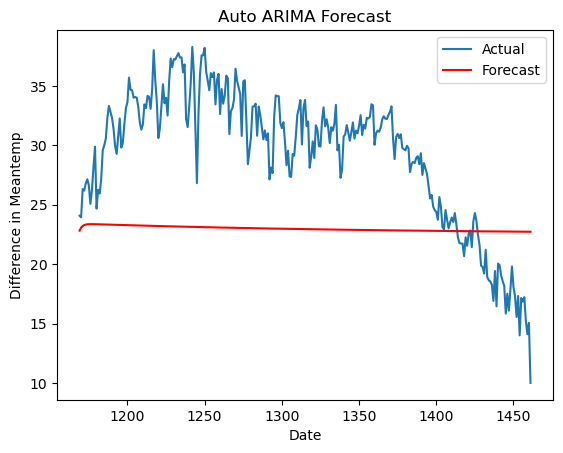

In [54]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Fit auto ARIMA model
auto_arima_model = auto_arima(train['meantemp'], seasonal=False, stepwise=True, suppress_warnings=True)
print(f"Best ARIMA Order: {auto_arima_model.order}")

# Forecast
arima_pred = auto_arima_model.predict(n_periods=len(test))

# Calculate error
error = mean_squared_error(test['meantemp'], arima_pred)
print('Test MSE: %.3f' % error)

# Plot the results
plt.plot(test.index, test['meantemp'], label='Actual')
plt.plot(test.index, arima_pred, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Difference in Meantemp')
plt.title('Auto ARIMA Forecast')
plt.legend()
plt.show()








Best ARIMA Order: (2, 0, 1)
AIC: 4440.66213431011
Test MSE: 69.941
Test RMSE: 8.363
Test MAE: 7.509
Test R^2: -1.185


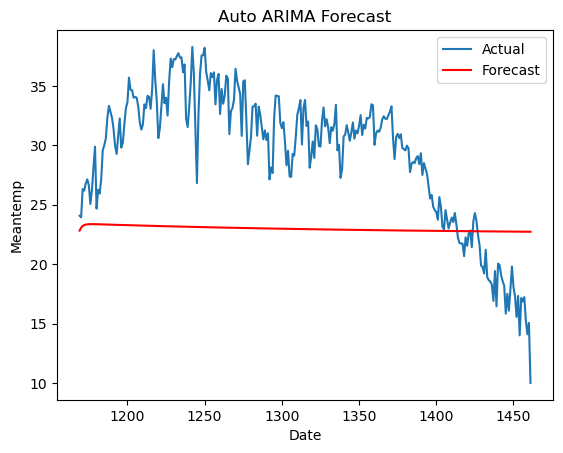

In [55]:
# Fit auto ARIMA model
auto_arima_model = auto_arima(train['meantemp'], seasonal=False, stepwise=True, suppress_warnings=True)
print(f"Best ARIMA Order: {auto_arima_model.order}")
print(f"AIC: {auto_arima_model.aic()}")

# Forecast
arima_pred = auto_arima_model.predict(n_periods=len(test))

# Evaluation metrics
mse = mean_squared_error(test['meantemp'], arima_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['meantemp'], arima_pred)
r2 = r2_score(test['meantemp'], arima_pred)

print(f"Test MSE: {mse:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test R^2: {r2:.3f}")

# Plot the results
plt.plot(test.index, test['meantemp'], label='Actual')
plt.plot(test.index, arima_pred, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Meantemp')
plt.title('Auto ARIMA Forecast')
plt.legend()
plt.show()










In [68]:
# SARIMAX

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model parameters
order = (1, 1, 1)  # Non-seasonal order (p, d, q)
seasonal_order = (1, 1, 1, 7)  # Seasonal order (P, D, Q, S)  

# Fit the SARIMA model
sarima_model = SARIMAX(endog=train['meantemp'], exog=train[['humidity', 'wind_speed']],
                       order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Make predictions
sarima_pred = sarima_model_fit.predict(start=test.index[0], end=test.index[-1],
                                            exog=test[['humidity', 'wind_speed']])

# Calculate error
mse = mean_squared_error(test['meantemp'], sarima_pred)
r2 = r2_score(test['meantemp'], sarima_pred)
print('Test MSE:', mse)
print('Test R²: %.3f' % r2)

Test MSE: 44.44656968762201
Test R²: -0.388


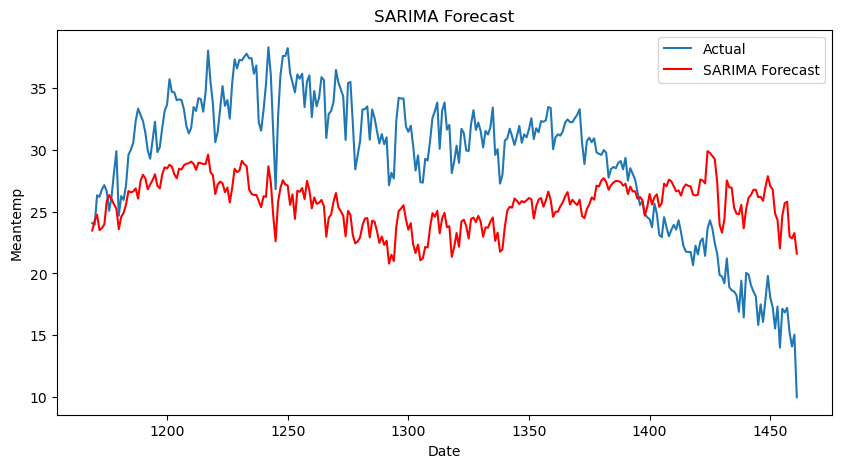

In [69]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(test.index, test['meantemp'], label='Actual')
plt.plot(test.index, sarima_pred, color='red', label='SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Meantemp')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=8007.623, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4509.874, Time=1.16 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=6237.601, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=10905.678, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=4507.905, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=4509.874, Time=0.27 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=4481.512, Time=0.16 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=4483.418, Time=0.35 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(3,0,0)(0,0,0)[7] intercept   : AIC=4473.403, Time=0.26 sec
 ARIMA(3,0,0)(1,0,0)[7] intercept   : AIC=4475.039, Time=2.10 sec
 ARIMA(3,0,0)(0,0,1)[7] intercept   : AIC=4475.039, 

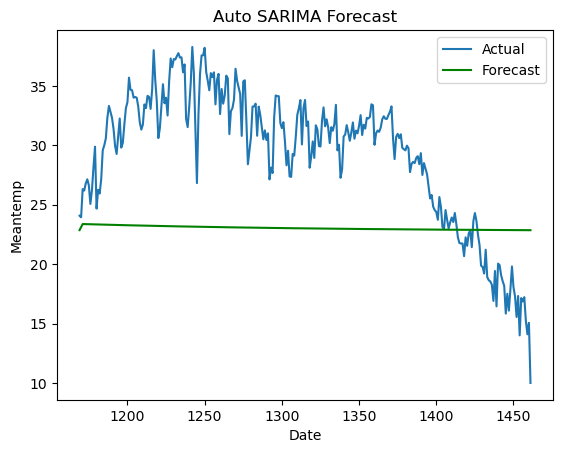

In [57]:
# Fit auto SARIMA model
auto_sarima_model = auto_arima(
    train['meantemp'],
    seasonal=True,
    m=7,  # Set this based on your data seasonality (e.g., 12 for monthly data, 7 for daily data with weekly seasonality)
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

print(f"Best SARIMA Order: {auto_sarima_model.order} Seasonal Order: {auto_sarima_model.seasonal_order}")
print(f"AIC: {auto_sarima_model.aic()}")

# Forecast
sarima_pred = auto_sarima_model.predict(n_periods=len(test))

# Evaluation metrics
mse = mean_squared_error(test['meantemp'], sarima_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['meantemp'], sarima_pred)
r2 = r2_score(test['meantemp'], sarima_pred)

print(f"Test MSE: {mse:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test R^2: {r2:.3f}")

# Plot the results
plt.plot(test.index, test['meantemp'], label='Actual')
plt.plot(test.index, sarima_pred, color='green', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Meantemp')
plt.title('Auto SARIMA Forecast')
plt.legend()
plt.show()

20:28:10 - cmdstanpy - INFO - Chain [1] start processing
20:28:11 - cmdstanpy - INFO - Chain [1] done processing


Test MSE: 7.629
Test R²: 0.762


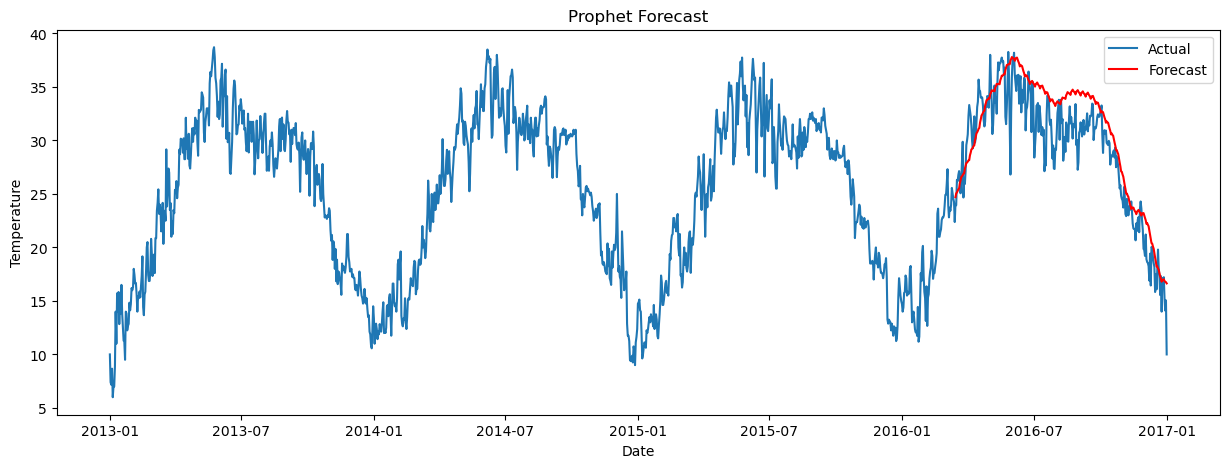

In [34]:
from prophet import Prophet

# Rename columns for Prophet
df_prophet = df.reset_index().rename(columns={'date': 'ds', 'meantemp': 'y'})

# Split the data into training and testing sets
train_size = int(len(df_prophet) * 0.8)
p_train, p_test = df_prophet.iloc[:train_size], df_prophet.iloc[train_size:]

# Initialize and fit the Prophet model with additional features
prop_model = Prophet()

prop_model.fit(p_train)

# Make future dataframe and include additional features
future = prop_model.make_future_dataframe(periods=len(p_test), freq='D')

# Make predictions
forecast = prop_model.predict(future)

# Extract the forecasted values for the test period
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[p_test['ds']]

# Calculate error and R²
mse = mean_squared_error(p_test['y'], predicted['yhat'])
r2 = r2_score(p_test['y'], predicted['yhat'])
print('Test MSE: %.3f' % mse)
print('Test R²: %.3f' % r2)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual')
plt.plot(predicted.index, predicted['yhat'], color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Prophet Forecast')
plt.legend()
plt.show()

In [70]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import math

prophet_mape = mean_absolute_percentage_error(pred_df["meantemp"].values, pred_df["prophet_yhat"].values)
prophet_r = r2_score(pred_df["meantemp"].values, pred_df["prophet_yhat"].values)
prophet_rmse = math.sqrt(mean_squared_error(pred_df["meantemp"].values, pred_df["prophet_yhat"].values))

arima_mape = mean_absolute_percentage_error(pred_df["meantemp"].values, pred_df["arima_pred"].values)
arima_r = r2_score(pred_df["meantemp"].values, pred_df["arima_pred"].values)
arima_rmse = math.sqrt(mean_squared_error(pred_df["meantemp"].values, pred_df["arima_pred"].values))

sarima_mape = mean_absolute_percentage_error(pred_df["meantemp"].values, pred_df["sarima_pred"].values)
sarima_r = r2_score(pred_df["meantemp"].values, pred_df["sarima_pred"].values)
sarima_rmse = math.sqrt(mean_squared_error(pred_df["meantemp"].values, pred_df["sarima_pred"].values))

######## monthly predictions #############

arima_mape_m = mean_absolute_percentage_error(m_test["meantemp"].values, m_test["arima_pred_m"].values)
arima_r_m = r2_score(m_test["meantemp"].values, m_test["arima_pred_m"].values)
arima_rmse_m = math.sqrt(mean_squared_error(m_test["meantemp"].values, m_test["arima_pred_m"].values))

sarima_mape_m = mean_absolute_percentage_error(m_test["meantemp"].values, m_test["sarima_pred_m"].values)
sarima_r_m = r2_score(m_test["meantemp"].values, m_test["sarima_pred_m"].values)
sarima_rmse_m = math.sqrt(mean_squared_error(m_test["meantemp"].values, m_test["sarima_pred_m"].values))

autoarima_mape_m = mean_absolute_percentage_error(m_test["meantemp"].values, m_test["auto_arima_pred"].values)
autoarima_r_m = r2_score(m_test["meantemp"].values, m_test["auto_arima_pred"].values)
autoarima_rmse_m = math.sqrt(mean_squared_error(m_test["meantemp"].values, m_test["auto_arima_pred"].values))

compare_df = {
        'Prophet daily': [prophet_mape,prophet_rmse,prophet_r], 
        'ARIMA daily': [arima_mape,arima_rmse,arima_r],
        'SARIMA daily': [sarima_mape,sarima_rmse,sarima_r],
        'ARIMA Monthly': [arima_mape_m,arima_rmse_m,arima_r_m], 
        'SARIMA Monthly': [sarima_mape_m,sarima_rmse_m,sarima_r_m],
        'autoARIMA Monthly': [autoarima_mape_m,autoarima_rmse_m,autoarima_r_m]
             }

compare_df = pd.DataFrame(compare_df,index=['MAE','RMSE','R2'])
compare_df

NameError: name 'pred_df' is not defined

Test MSE: 59.67035120080613
Test R²: -0.864


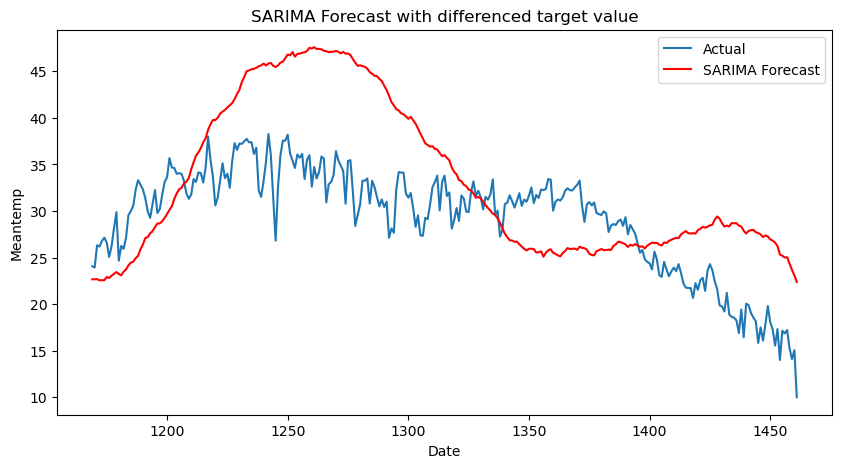

In [71]:
# SARIMAX with differenced target (will not be compared with other models)

# Fit the SARIMA model
sarima_model = SARIMAX(endog=train['meantemp_diff'], exog=train[['humidity', 'wind_speed']],
                       order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Make predictions
sarima_pred_diff = sarima_model_fit.predict(start=test.index[0], end=test.index[-1],
                                            exog=test[['humidity', 'wind_speed']])

# Convert differenced predictions back to the original scale
# Start the conversion from the last known original value in the training set
last_original_value = train['meantemp'].iloc[-1]
sarima_pred = sarima_pred_diff.cumsum() + last_original_value

# Calculate error
mse = mean_squared_error(test['meantemp'], sarima_pred)
r2 = r2_score(test['meantemp'], sarima_pred)
print('Test MSE:', mse)
print('Test R²: %.3f' % r2)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(test.index, test['meantemp'], label='Actual')
plt.plot(test.index, sarima_pred, color='red', label='SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Meantemp')
plt.title('SARIMA Forecast with differenced target value')
plt.legend()
plt.show()